
# Data curation

Man Ho Wong, University of Pittsburgh | April 28, 2022

*Jupyter notebooks are not always rendered properly on GitHub. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_curation.ipynb) if that happens.*

##### Script header

In [1]:
# Python libraries and packages required
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                    # For pretty printing
import pylangacq                 # See Section 2.1 for installation
from tqdm import tqdm            # For showing progress bar (optional)

# Load data from last run to skip section 2:
search_result = pickle.load(open('../data/childes/search_result.pkl', 'rb'))
data_idx = pickle.load(open('../data/childes/data_idx_unprocessed.pkl', 'rb'))

# Pretty printing for better readability:
# - print dict in compact format instead of one item per line
# - Items will be in alphabetical order; Counter in descending order
# - Nested Dict will be printed with suitable indentation
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

---

# 1 Overview

> Data processing pipeline:  
>`data_curation.ipynb` <-- You are here  
>[`data_preprocessing.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb)   
>[`exploratory_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb)  
>[`vocabulary_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/vocabulary_analysis.ipynb)

This notebook is the first step of the data processing and analysis pipeline of the project. I will screen for suitable corpora needed for this project in the Child Language Data Exchange System, [CHILDES](https://childes.talkbank.org/).  
>MacWhinney, B. (2000). The CHILDES Project: Tools for analyzing talk. Third Edition. Mahwah, NJ: Lawrence Erlbaum Associates.

I will first demonstrate how the data stored in CHAT format (the standard data format in CHILDES) can be read and accessed with the PyLangAcq package. I will also explore the data to get a sense of the contents and data structure of the corpora (e.g., participant information, annotations, data format, etc.). I will then screen for suitable corpora containing the data I need for this project, i.e., child speech (CS) and child-directed speech (CDS). To prepare for the next step (data cleaning and preprocessing), I will look at some basic statistics about the dataset curated in this notebook, as well as the demographics of the participants.

The curated dataset will be stored locally and indexed by a `DataFrame`, `data_idx`, for easy access later. `data_idx` will be pickled and stored locally.

### Table of contents
1. [Overview](#1-overview)
2. [Data format and structure](#2-data-format-and-structure)
    - [2.1 Acccessing data in CHAT file](#21-acccessing-data-in-chat-file)
3. [Searching for suitable corpora in CHILDES](#3-searching-for-suitable-corpora-in-childes)
    - [3.1 Search strategy](#31-search-strategy)
    - [3.2 Running the search](#32-running-the-search)
4. [Composition of curated data](#4-composition-of-curated-data)
    - [4.1 Token count](#41-token-count)
    - [4.2 Utterance count](#42-utterance-count)
    - [4.3 Dataset composition](#43-dataset-composition)
    - [4.4 Demographics of participants](#44-demographics-of-participants)

---

# 2 Data format and structure

CHILDES is a multilingual database containing corpora with transcriptions, audio recordings and/or video recordings of child speech (CS) and child-directed speech (CDS) at different developmental stages. Each corpus has a separate directory for each participant, and each directory contains the recording transcripts stored in CHAT formats. ([Example](https://childes.talkbank.org/access/Eng-NA/Brown.html))

For this project, I will need to collect the transcipts for both the child speech and the associated CDS. Additionally, I will need the participant information (i.e. child age, sex and socioeconomic status (SES), mother's education) and some basic annotations of the words (i.e. morphemes and lexical categories). Participant information can be found in the header of each CHAT file as the metadata of the file. Annotation information can be found as dependent tiers embedded in the transcription.

Let's take a quick look at a sample CHAT file first to see how the data is organized.


## 2.1 Acccessing data in CHAT file

### Reading CHAT file

The `PyLangAcq` package allows users to read CHAT files directly from a zip file. You can download and install it with the following code:  
`$ pip install --upgrade pylangacq`

For documentation, you can visit their [website](https://pylangacq.org/).

I will use the Brown Corpus of CHILDES as an example below. The corpus has been downloaded from [here](https://childes.talkbank.org/data/Eng-NA/Brown.zip) and stored under `../data/data_samples/Brown.zip`. There are three folders in this corpus, each folder contains a dataset (a collection of CHAT files) for each child:

```
Brown.zip/  
    |--Adam/  
    |--Eve/  
    |--Sarah/
```

I will use the `read_chat()` function of `PyLangAcq` to read all the CHAT files in the folder `Adam`:

In [2]:
# Read CHAT files in the folder 'Adam' in 'Brown.zip':
path = '../data/data_samples/Brown.zip'
adam = pylangacq.read_chat(path, 'Adam')

print(type(adam))
print('Number of CHAT files:', adam.n_files())

<class 'pylangacq.chat.Reader'>
Number of CHAT files: 55


In [3]:
# Ages when recordings were made
print('Ages (year, month, day):', adam.ages())  # output: a list of tuples

Ages (year, month, day): [(2, 3, 4), (2, 3, 18), (2, 4, 3), (2, 4, 15), (2, 4, 30), (2, 5, 12), (2, 6, 3), (2, 6, 17), (2, 7, 1), (2, 7, 14), (2, 8, 1), (2, 8, 16), (2, 9, 4), (2, 9, 18), (2, 10, 2), (2, 10, 16), (2, 10, 30), (2, 11, 13), (2, 11, 28), (3, 0, 11), (3, 0, 25), (3, 1, 9), (3, 1, 26), (3, 2, 9), (3, 2, 21), (3, 3, 4), (3, 3, 18), (3, 4, 1), (3, 4, 18), (3, 5, 1), (3, 5, 15), (3, 5, 29), (3, 6, 9), (3, 7, 7), (3, 8, 1), (3, 8, 14), (3, 8, 26), (3, 9, 16), (3, 10, 15), (3, 11, 1), (3, 11, 14), (4, 0, 14), (4, 1, 15), (4, 2, 17), (4, 3, 9), (4, 4, 1), (4, 4, 13), (4, 5, 11), (4, 6, 24), (4, 7, 1), (4, 7, 29), (4, 9, 2), (4, 10, 2), (4, 10, 23), (5, 2, 12)]


As shown above, `read_chat()` read the CHAT files and creates a `Reader` object. This is a `dataclass` storing data and metadata across all the CHAT files in `Adam`. You can access the data stored in the `Reader` by calling the appropriate methods/ attributes, such as `.n_files()` for number of CHAT files in the dataset. For example, `Adam` has 55 CHAT files. We can also get the ages when recordings were made by calling `.ages()`. Let's see what other information we can get from the `Reader` object in the next section.

### Accessing metadata stored in a CHAT file

Metadata such as age range, date of recording, participants, etc. are stored in the header of each CHAT file. We can access such information by retrieving the `.header()` attribute. Here is the header for the first CHAT file in `adam`:

In [4]:
cp.pprint(adam.headers()[0])

{'Comment': 'Birth of CHI is 4-JUL-1960',
 'Date': {datetime.date(1962, 10, 9), datetime.date(1962, 10, 8)},
 'Languages': ['eng'],
 'PID': '11312/c-00015632-1',
 'Participants': {'CHI': {'age': '2;03.04',
                          'corpus': 'Brown',
                          'custom': '',
                          'education': '',
                          'group': 'TD',
                          'language': 'eng',
                          'name': 'Adam',
                          'role': 'Target_Child',
                          'ses': 'MC',
                          'sex': 'male'},
                  'COL': {'age': '',
                          'corpus': 'Brown',
                          'custom': '',
                          'education': '',
                          'group': '',
                          'language': 'eng',
                          'name': 'Colin_Fraser',
                          'role': 'Investigator',
                          'ses': '',
                     

The output above, is a nested `dictionary`. To retrieve a specific piece of information we need, we can use its `dictionary` key as usual.  
Let's check if 'Adam' is a male as their biblical name suggests:

In [5]:
adam.headers()[0]['Participants']['CHI']['sex']

'male'


### Accessing annotations

Next, let's check what kinds of annotation are stored in each CHAT file. I will use the `.tokens()` method to access the annotated tokens. This method returns a `list` of `Token` objects:

In [6]:
tokens = adam.tokens()
tokens[:5]  # first five tokens

[Token(word='play', pos='n', mor='play', gra=Gra(dep=1, head=2, rel='MOD')),
 Token(word='checkers', pos='n', mor='checker-PL', gra=Gra(dep=2, head=0, rel='INCROOT')),
 Token(word='.', pos='.', mor='', gra=Gra(dep=3, head=2, rel='PUNCT')),
 Token(word='big', pos='adj', mor='big', gra=Gra(dep=1, head=2, rel='MOD')),
 Token(word='drum', pos='n', mor='drum', gra=Gra(dep=2, head=0, rel='INCROOT'))]

Each `Token` is a `dataclass` with attributes (e.g. `word`,`pos`, etc.) as shown in the above example.  
Annotations for each word are stored as the `Token`'s attributes (i.e. attributes other than `word`):

In [7]:
print("Second token in 'Adam':")
print('Word = {}\nMorpheme = {}\nPart of speech = {}'.format(
    tokens[1].word, tokens[1].mor, tokens[1].pos))

Second token in 'Adam':
Word = checkers
Morpheme = checker-PL
Part of speech = n


---

# 3 Searching for suitable corpora in CHILDES

## 3.1 Search strategy

Now that we know what kinds of information are stored in each CHAT file and how we can access them, we can start planning our search accordingly.

### Identifying the scope of search

There are dozens of English corpora in CHILDES. We don't need to download them all at once just to look for the corpora we need. `PyLangAcq` allows user to read a corpus directly with the corpus's URL. We can read the corpora one by one, and keep only the ones we need. To get the URLs for all the North American (NA) English corpora, one can use a web scraping tool to get all the links from the database's website and look for the corpus URLs from there. However, a much faster way is to take advantage of the TalkBank's [browsable database](https://sla.talkbank.org/TBB/childes):  
1. navigate to CHILDES's North American English dataset (Eng-NA)
2. copy the list of corpora directly to a spreadsheet program and save it as a `csv` file (example: `data/data_samples/childes/eng_NA_corpus_list.csv`)
3. construct the download URL for each corpus simply with its name (see below)

CHILDES has a very well organized structure. Each corpus has the same download URL format as follow:  
`https://childes.talkbank.org/data/LANGUAGE/NAME_OF_CORPUS.zip`  
For example, the download URL for the Brown Corpus is: https://childes.talkbank.org/data/Eng-NA/Brown.zip

Let's see what corpora will be included in our search:

In [8]:
# Read the list of corpora into a Pandas Series:
corpus_list = pd.read_csv('../data/childes/eng_NA_corpus_list.csv', 
                          header=None, index_col=False, squeeze = True)

print('There are {} NA English corpora in CHILDES.'.format(len(corpus_list)))
print('Here are the first 10 corpora:')
corpus_list.head(10)

There are 47 NA English corpora in CHILDES.
Here are the first 10 corpora:


0        Bates
1    Bernstein
2        Bliss
3        Bloom
4     Bohannon
5    Braunwald
6        Brent
7        Brown
8        Clark
9    Demetras1
Name: 0, dtype: object

There are 47 NA English corpora in CHILDES that we can potentially use! Since there is a huge volume of data that we have to evaluate, we need a good strategy to make the data search more efficient. For this project, I will develop a search stretegy similar to a data collection process following PRISMA (Preferred Reporting Items for Systematic Reviews and Meta-Analyses) statement ([flow diagram](https://view.officeapps.live.com/op/view.aspx?src=http%3A%2F%2Fwww.prisma-statement.org%2Fdocuments%2FPRISMA_2020_flow_diagram_new_SRs_v1.docx&wdOrigin=BROWSELINK), [publication](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003583)), which is commonly used in medicine and life sciences for meta-analyses.

### Searching data in three phases

Instead of evaluating each of the CHAT files from all 47 corpora directly, I will perform the search in three phases, where each phase narrows down the scope of search. As the scope of search is becoming more manageable, I will use search criteria that are more specific. 

1. **Identification**  
    Identify relevant corpora fitting a set of basic criteria  
2. **Screening**  
    Screen for CHAT files containing the information we need  
3. **Refining**  
    Refine the dataset by filtering CHAT files with more specific criteria

## 3.2 Running the search

### Phase 1: Identification

I will first search for the corpora meeting the basic requirements of the project, i.e. corpora involving relevant participants (child for child speech analysis and mother for CDS analysis).

Here are the search criteria:
- Participants: data includes child or mother
- Child information: data contains child age, sex and socioeconomic status (SES) information
- Mother information: data contains socioeconomic status (SES), education information

To access participant information, we can first read the data into a `Reader` object, and then retrieve the header information from the `.headers` attribute.

#### About efficiency

Handling all corpora at once as one `Reader` object is not memory-efficient, but reading each single CHAT file into individual `Reader`s does not allow parallelized reading and parsing and thus it is less efficient. Therefore, instead of reading all corpora at once or reading each CHAT file one by one, I will read and evaluate one corpus (containing multiple CHAT files) at a time. Once a CHAT file in the corpus fits the criteria, the rest of the CHAT files will not be evaluated and I will move on to the next corpus (because CHAT files belonging to the same corpus are supposed to come from the same study contain similar information).

The `.headers` of a `Reader` contains a `list` of headers of *all* the CHAT files in the dataset.  
Let's look at our favorite dataset 'Adam' again. Here are the headers of the first two CHAT files in the `adam` reader:

In [9]:
cp.pprint(adam.headers()[:2])

[{'Comment': 'Birth of CHI is 4-JUL-1960',
  'Date': {datetime.date(1962, 10, 9), datetime.date(1962, 10, 8)},
  'Languages': ['eng'],
  'PID': '11312/c-00015632-1',
  'Participants': {'CHI': {'age': '2;03.04',
                           'corpus': 'Brown',
                           'custom': '',
                           'education': '',
                           'group': 'TD',
                           'language': 'eng',
                           'name': 'Adam',
                           'role': 'Target_Child',
                           'ses': 'MC',
                           'sex': 'male'},
                   'COL': {'age': '',
                           'corpus': 'Brown',
                           'custom': '',
                           'education': '',
                           'group': '',
                           'language': 'eng',
                           'name': 'Colin_Fraser',
                           'role': 'Investigator',
                           'ses': ''

To access the participant information in each header, one can loop through each header and index into the sub-level dictionary associated with the key `Participants`. For example:

In [10]:
for h in adam.headers():
    if 'MOT' in h ['Participants']:  # search criterion
        print('At least one file involves mother as a participant in the dataset "Adam"!')
        break  # Break the loop once the search criterion is met

At least one file involves mother as a participant in the dataset "Adam"!


Let's begin the first phase of the search:

In [11]:
search_result = []  # To store a list of corpora matching the criteria

# Search each corpus in the list:
for corpus_name in tqdm(corpus_list):  # tqdm for progress bar
    
    # Download URL for the corpus:
    corpus_url = 'https://childes.talkbank.org/data/Eng-NA/'+corpus_name+'.zip'
    
    # read the corpus into a Reader object:
    corpus = pylangacq.read_chat(corpus_url)
   
    # Search criteria:  
    # - Child ('CHI') is included as participant.
    # - Info about Child's SES or mother's SES/education is provided.
    # Note: Check if 'MOT' is present before checking SES/education info
    #       (if the condition before 'and' is False, the second condition won't
    #       be evaluated. This is not only more efficient, but also prevents
    #       error when evaluating the second condition if 'MOT' is absent)
    
    for h in corpus.headers():
        if (
            # 'CHI' must be included
            ('CHI' in h['Participants']) 
            
            and
            
            # Must contain info about either SES or mother's education
            (
                # Child's or mother's SES 
                ((h['Participants']['CHI']['ses'] != '') or
                (('MOT' in h['Participants']) and (h['Participants']['MOT']['ses'] != '')))
                
                or
                
                # Mother's education
                (('MOT' in h['Participants']) and (h['Participants']['MOT']['education'] != ''))
            )
            
        ):
            search_result.append(corpus_name)  # store corpus name in 'search_result'
            break  # Break the for loop and move on to the next corpus

print('Search completed! {} corpora found!'.format(len(search_result)))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [07:04<00:00,  9.03s/it]

Search completed! 13 corpora found!


Let's see which corpora contain the data we need:

In [11]:
print('\n{} corpora matching the criteria:'.format(len(search_result)))
print(search_result)


13 corpora matching the criteria:
['Bates', 'Bernstein', 'Brown', 'Clark', 'Demetras2', 'Gleason', 'HSLLD', 'Hall', 'Hicks', 'Nelson', 'NewmanRatner', 'Post', 'VanHouten']


Nice! We have narrowed down the number of corpora we need to process from 47 to 13.  

#### Downloading data to local drive

Next, I will download the zip files for the corpora to the local drive and extract them to the folder `../data/childes/`.

In [ ]:
import os
import urllib.request
import zipfile

# Where zip files will be stored locally
target_dir = '../data/childes/corpus_zip/'

# Create a folder to store the zip files
os.mkdir(target_dir)

for corpus_name in search_result:
    
    print('Downloading and extracting {}...'.format(corpus_name))
    
    # Corpus's download URL:
    corpus_url = 'https://childes.talkbank.org/data/Eng-NA/'+corpus_name+'.zip'
    
    # Path in local drive:
    zip_path = target_dir + corpus_name + '.zip'
    
    # Download corpus from URL
    urllib.request.urlretrieve(corpus_url, zip_path)
    
    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall('../data/childes')
        
print('Done! Zip files were stored in {} \nand extracted to {}.'
      .format(target_dir, '../data/childes'))

### Phase 2: Screening

All the corpora matching the search criteria in Phase 1 were downloaded to local drive. From now on, I will read the data locally instead of remotely.

Since not all the CHAT files were inspected in Phase 1, we are not sure whether all files match the search criteria and could be used for data analysis. In addition, some corpora contain dummy files, and some contain data we don't need, such as parent interviews ([example](https://sla.talkbank.org/TBB/childes/Eng-NA/Bernstein/Interview/Alice/alice1.cha)). Therefore, in Phase 2, I will inspect all the files to screen for files that I need. In this Phase, I will also include child's age in the search criteria. Because I am studying vocabulary development in early childhood, I will exclude the files  with children older than 6 years for now (I will refine the age range later). I will also create a `DataFrame` to index all the CHAT files that match the search criteria and store their header information for further data processing.

In [12]:
# Create lists to store header variables
file_path_list   = []
corpus_name_list = []
year_list        = []  # recording year
participant_list = []  # participants of recording
chi_name_list    = []  # Child's name
chi_age_d_list   = []  # Child's age in days
chi_age_m_list   = []  # Child's age in months
chi_sex_list     = []  # Child's sex
chi_group_list   = []  # Child's group (e.g. typically developed)
chi_ses_list     = []  # Child's SES (socioeconomic status; same as mother's)
mot_edu_list     = []  # Mother's education
situation_list   = []  # Situation of recording (e.g. play session)
activity_list    = []  # Activities during recording (e.g. Toy play)
study_type_list  = []  # type of study (e.g. longitudinal study)

for corpus_name in tqdm(search_result):  # tqdm for progress bar
    
    # Read the entire corpus into a Reader object:
    corpus = pylangacq.Reader.from_dir('../data/childes/'+corpus_name)
    
    for f in corpus:                    # Inspect each file in the corpus
        h = f.headers()[0]              # Header of each file     
        if 'CHI' in h['Participants']:  # Include only the files with 'CHI' info
            
            age_raw     = f.ages()[0]   # Age in raw format
            chi_age_d   = (age_raw[0]*12 + age_raw[1])*30 + age_raw[2]
            chi_age_m   = age_raw[0]*12 + age_raw[1] + round(age_raw[2]/30,1)

            if chi_age_m <= 72:  # Include file only only children <= 72 months
            
                # Get info we need from the header
                file_path    = f.file_paths()[0].replace('\\','/')                
                corpus_name  = h['Participants']['CHI']['corpus']
                participants = f.participants()
                chi_name     = h['Participants']['CHI']['name']
                chi_sex      = h['Participants']['CHI']['sex']
                chi_group    = h['Participants']['CHI']['group']
                chi_ses      = h['Participants']['CHI']['ses']
                
                # Some fields may not exist in header, so use if condition:
                year      = (list(h['Date'])[0].year if 'Date' in h else np.nan)
                situation = (h['Situation'] if 'Situation' in h else '')
                activities= (h['Activities'] if 'Activities' in h else '')
                study_type= (h['Types'] if 'Types' in h else '')
                
                # Get 'MOT' info only if 'MOT' exsits
                if 'MOT' in h['Participants']:
                    mot_edu = h['Participants']['MOT']['education']                    
                    # Just in case SES info is stored in 'MOT' instead of 'CHI'
                    if h['Participants']['MOT']['ses'] != '':
                        chi_ses = h['Participants']['MOT']['ses']
                else:             # Prevent using value from last iteration when
                    mot_edu = ''  #   'MOT' doesn't exist
                                              
                file_path_list.append(file_path) 
                corpus_name_list.append(corpus_name)
                year_list.append(year)
                participant_list.append(participants)
                chi_name_list.append(chi_name)
                chi_age_d_list.append(chi_age_d)
                chi_age_m_list.append(chi_age_m)
                chi_sex_list.append(chi_sex)
                chi_group_list.append(chi_group)
                chi_ses_list.append(chi_ses)
                mot_edu_list.append(mot_edu)
                situation_list.append(situation)
                activity_list.append(activities)
                study_type_list.append(study_type)
                
# Build a DataFrame to store header information
data_idx = pd.DataFrame({'file_path':file_path_list,
                         'corpus':corpus_name_list,
                         'year': year_list,
                         'participants': participant_list,
                         'name':chi_name_list,
                         'age_d':chi_age_d_list,
                         'age_m':chi_age_m_list,
                         'sex':chi_sex_list,
                         'group':chi_group_list,
                         'ses':chi_ses_list,
                         'mot_edu':mot_edu_list,
                         'situation':situation_list,
                         'activities':activity_list,
                         'study_type':study_type_list
                        })

print('Done!')

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:08<00:00, 14.52s/it]

Done!


In [13]:
# Fill unspecified entries (except 'year') with 'unspecified'
data_idx.replace(to_replace = '', value = 'unspecified', inplace=True)
data_idx.head()

,file_path,corpus,year,participants,name,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


Let's take a look at a record in the DataFrame and check if everything is correct:

In [14]:
data_idx.iloc[1000,:]

file_path                 ../data/childes/HSLLD/HV2/ER/sarer2.cha
corpus                                                      HSLLD
year                                                       1990.0
participants                                      {INV, CHI, MOT}
name                                                 Target_Child
age_d                                                        1713
age_m                                                        57.1
sex                                                        female
group                                                 unspecified
ses                                                   unspecified
mot_edu                                                        10
situation       Second home visit; elicited report occurred in...
activities                                        Elicited report
study_type                                    long, narrative, TD
Name: 1000, dtype: object

According to `data_idx`, this record is from the Corpus 'HSLLD'. The child is a female whose mother's education level is '10'. Is the information correct? Let's read the file header associated with this record:

In [15]:
sample = pylangacq.Reader.from_files([data_idx.file_path[1000]])

print("Sex of child participant:", sample.headers()[0]['Participants']['CHI']['sex'])
print("Mother's education:", sample.headers()[0]['Participants']['MOT']['education'])

Sex of child participant: female
Mother's education: 10


Everything looks good!

### Phase 3: Refining

This will be done on the fly during data analysis.

---

# 4 Composition of curated data

## 4.1 Token count

We can use the methods `.tokens()` and `.utterances` to access the token and utterance information stored in the `Reader` objects. Let's see how many tokens are three in these corpora:

In [16]:
# Read each corpus into a reader
readers = [pylangacq.Reader.from_files(data_idx[data_idx.corpus==c].file_path)
           for c in tqdm(search_result)]

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:48<00:00, 12.93s/it]


In [17]:
# count tokens in each reader and create a dict
n_tok_dict = {c:len(readers[i].tokens()) for i,c in enumerate(search_result)}

# convert n_tok_dict to DataFrame for easy access later
tok_by_corpus = pd.DataFrame(n_tok_dict.items(),
                             columns=['corpus','token_count'])

print(tok_by_corpus)
print('\nTotal token count:', sum(tok_by_corpus.token_count))

          corpus  token_count
0          Bates        56304
1      Bernstein        73531
2          Brown       880322
3          Clark       258699
4      Demetras2        99363
5        Gleason       317306
6          HSLLD      1183118
7           Hall      1340000
8          Hicks        39399
9         Nelson        36328
10  NewmanRatner      1046875
11          Post       185246
12     VanHouten        63884

Total token count: 5580375



## 4.2 Utterance count

Similarly, we can access the utterance infomation stored in each `Reader` object. For example:

In [18]:
file = data_idx.file_path[0]  # first file in 'data_idx'
reader = pylangacq.Reader.from_files([file])
reader.utterances()[3]  # 4th utterance

Utterance(participant='CHI', tokens=[Token(word='yeah', pos='co', mor='yeah', gra=Gra(dep=1, head=0, rel='INCROOT')), Token(word='.', pos='.', mor='', gra=Gra(dep=2, head=1, rel='PUNCT'))], time_marks=None, tiers={'CHI': 'yeah .', '%mor': 'co|yeah .', '%gra': '1|0|INCROOT 2|1|PUNCT', '%act': 'takes chicken'})

The example above shows the second utterance and their annotation information in the first corpus ('Bates'), including the words, the speaker and more. To look at child-directed speech (CDS) specifically, we can set the `.utterances()`'s `participants` option to `MOT`:

In [19]:
reader.utterances(participants='MOT')[0] # first utterance by mother

Utterance(participant='MOT', tokens=[Token(word="what's", pos='pro:int', mor='what', gra=Gra(dep=1, head=2, rel='SUBJ')), Token(word='CLITIC', pos='cop', mor='be&3S', gra=Gra(dep=2, head=0, rel='ROOT')), Token(word='that', pos='pro:dem', mor='that', gra=Gra(dep=3, head=2, rel='PRED')), Token(word='?', pos='?', mor='', gra=Gra(dep=4, head=2, rel='PUNCT'))], time_marks=None, tiers={'MOT': "what's that ?", '%mor': 'pro:int|what~cop|be&3S pro:dem|that ?', '%gra': '1|2|SUBJ 2|0|ROOT 3|2|PRED 4|2|PUNCT', '%act': 'holds object out to Amy'})

Next, I will look at how many utterances are there in the data. How many utterances are there in the child speech, and how many in the mother's CDS?

In [20]:
# count tokens in each reader and create a dict
n_utt_dict_chi = {c:len(readers[i].utterances(participants='CHI'))
                  for i,c in enumerate(search_result)}
n_utt_dict_mot = {c:len(readers[i].utterances(participants='MOT'))
                  for i,c in enumerate(search_result)}

# convert dict to DataFrame
utt_by_corpus = pd.DataFrame({'Corpus':n_utt_dict_chi.keys(),
                              'utt_count_chi':n_utt_dict_chi.values(),
                              'utt_count_mot':n_utt_dict_mot.values()})
# basic stats
utt_sum_chi = sum(n_utt_dict_chi.values())
utt_sum_mot = sum(n_utt_dict_mot.values())
utt_sum = utt_sum_chi + utt_sum_mot
utt_chi_pc = round (utt_sum_chi/utt_sum*100, 2)  # Child utterance percentage
utt_mot_pc = round (utt_sum_mot/utt_sum*100, 2)  # Mother utterance percentage

print(utt_by_corpus)
print('\nChild utterance count:', utt_sum_chi)
print('\nMother utterance count:', utt_sum_mot)
print('\nTotal utterance count:', utt_sum)
print('\nUtterance count percentage: {}% by child; {}% by mother'
      .format(utt_chi_pc, utt_mot_pc))

          Corpus  utt_count_chi  utt_count_mot
0          Bates           5572           8579
1      Bernstein            167          11160
2          Brown          96952          60252
3          Clark          18169           1944
4      Demetras2           9411           6227
5        Gleason          20137          19545
6          HSLLD          77528         110117
7           Hall          75655          37028
8          Hicks           2970              0
9         Nelson           4893              8
10  NewmanRatner          28934         160717
11          Post           8380          20189
12     VanHouten           5132           4770

Child utterance count: 353900

Mother utterance count: 440536

Total utterance count: 794436

Utterance count percentage: 44.55% by child; 55.45% by mother


## 4.3 Dataset composition

Our dataset consists of 13 corpora from different studies, created for different purposes. Let's take a look at some basic information about the dataset composition.

In [21]:
# Prepare data for plotting

# Re-name participant labels for better presentation
participants_ser = data_idx.participants.map(list)  # a series of participant lists
for participants in participants_ser:
    for idx, role in enumerate(participants):
        if role != 'CHI' and role != 'MOT':
            participants[idx] = 'Others'
    participants.sort()

# Remove repeated elements in each entry by converting list to set
participants_ser = participants_ser.map(set)

# Since .groupby() method doesn't work on set, convert set to string first.
# Convert set to string by joining all items in the set
participants_ser = participants_ser.map(' + '.join)

# Count files by participant role
participant_count = participants_ser.groupby(participants_ser).aggregate('count')

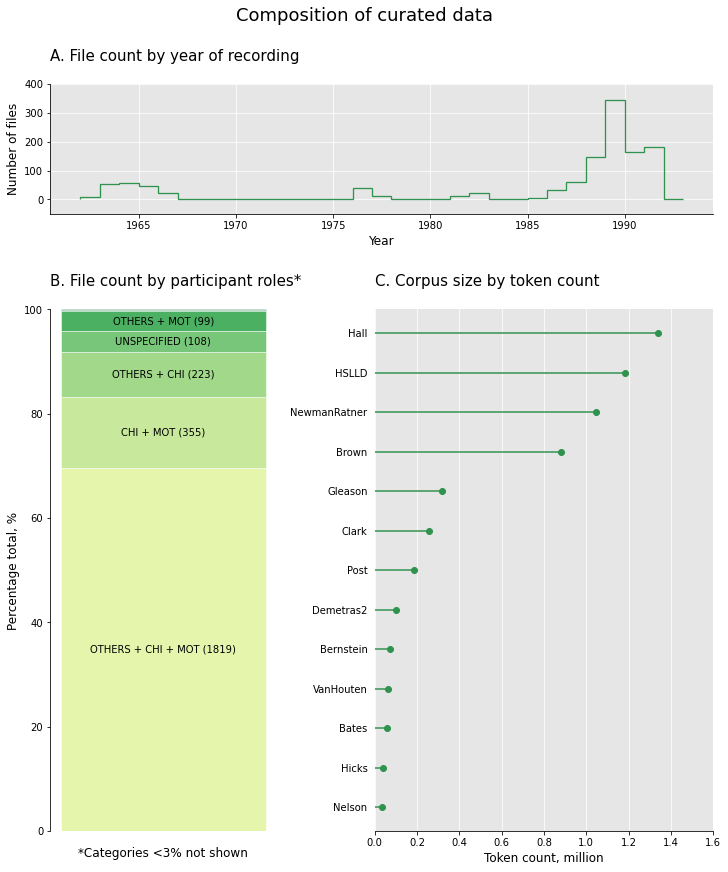

In [22]:
# Create a figure object

# Subplot dimension ratio
gs_kw = dict(width_ratios=[1,1.5], height_ratios=[1,4])

# Create a figure with 5 axes (i.e. 5 subplots), namely A, B, C, D, E
fig, ax = plt.subplot_mosaic([['A','A'],
                              ['B','C']],  # Subplot C spans across two grids
                              gridspec_kw=gs_kw, figsize=(10,12),
                              constrained_layout=True)
cmap = plt.cm.YlGn  # color map
accent_color = cmap(0.7)

# ==============================================================================
# Plotting

# ------------------------------------------------------------------------------
# Plot A
ax['A'].hist(data_idx.year, 31, histtype='step', color=accent_color, lw='1.3')

# ------------------------------------------------------------------------------
# Plot B
participant_count = participant_count.sort_values(ascending=False)
participant_pc = participant_count/sum(participant_count)*100
colors = cmap(np.linspace(0.2, 0.8, len(participant_pc)))

curr_sum = 0
for i, pc in enumerate(participant_pc):
    bottom = curr_sum
    ax['B'].bar('x', pc, label=participant_pc.index[i], bottom=bottom,
                color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc
    if participant_pc.index[i] == '':
        label = "Unspecified ({})".format(participant_count[i]).upper()
    elif pc >= 3:
        label = "{} ({})".format(participant_pc.index[i],
                                 participant_count[i]).upper()
    else:
        label = ''
    label_ypos = curr_sum - (pc/2)
    ax['B'].text(0, label_ypos, label, ha="center", va="center")

# ------------------------------------------------------------------------------
# Plot C
tok_by_corpus.sort_values(by='token_count', inplace=True, ascending=True)
marker, stem, base = ax['C'].stem(tok_by_corpus.corpus,
                                  tok_by_corpus.token_count/10**6,
                                  orientation='horizontal', basefmt='none')
plt.setp(marker, 'color', accent_color)
plt.setp(stem, 'color', accent_color)

# ------------------------------------------------------------------------------
# Subplot A settings
ax['A'].set_xlabel('Year', size=12)
ax['A'].set_ylabel('Number of files', size=12)
ax['A'].set_ylim([-50,400])
ax['A'].spines[['top', 'right']].set_visible(False)
ax['A'].grid(axis='both', color='w')
ax['A'].set_facecolor('0.9')

# Subplot B settings
ax['B'].get_xaxis().set_visible(False)
ax['B'].set_ylabel('Percentage total, %', size=12)
ax['B'].set_ylim([0,100])
ax['B'].spines[['top','bottom', 'right']].set_visible(False)
ax['B'].text(0, -3, '*Categories <3% not shown', ha="center", va="top", size=12)

# Subplot C settings
ax['C'].set_xlabel('Token count, million', size=12)
# ax['C'].tick_params(axis='x', labelrotation = 45)
ax['C'].spines[['top', 'left', 'right']].set_visible(False)
ax['C'].set_xlim([0, 1.6])
ax['C'].yaxis.set_ticks_position('none') 
ax['C'].grid(axis='x', color='w')
ax['C'].set_facecolor('0.9')

# ------------------------------------------------------------------------------
# Set figure and subplot titles
ax['A'].set_title('\nA. File count by year of recording\n',
                  loc='left', size=15)
ax['B'].set_title('\nB. File count by participant roles*\n',
                  loc='left', size=15)
ax['C'].set_title('\nC. Corpus size by token count\n',
                  loc='left', size=15)

fig.suptitle('Composition of curated data', fontsize=18)

# Save figure
# plt.savefig('../reports/images/data_composition_unprocessed.svg', bbox_inches='tight', dpi=150)
plt.show()

## 4.4 Demographics of participants

Vocabulary development can be influenced by a participant's background, such as age, sex, SES, mother's education and developmental groups (e.g. typically developing children). Let's look at these factors first to get a better idea of how the demographics looks like and what kinds of information are available in the data for further analysis.

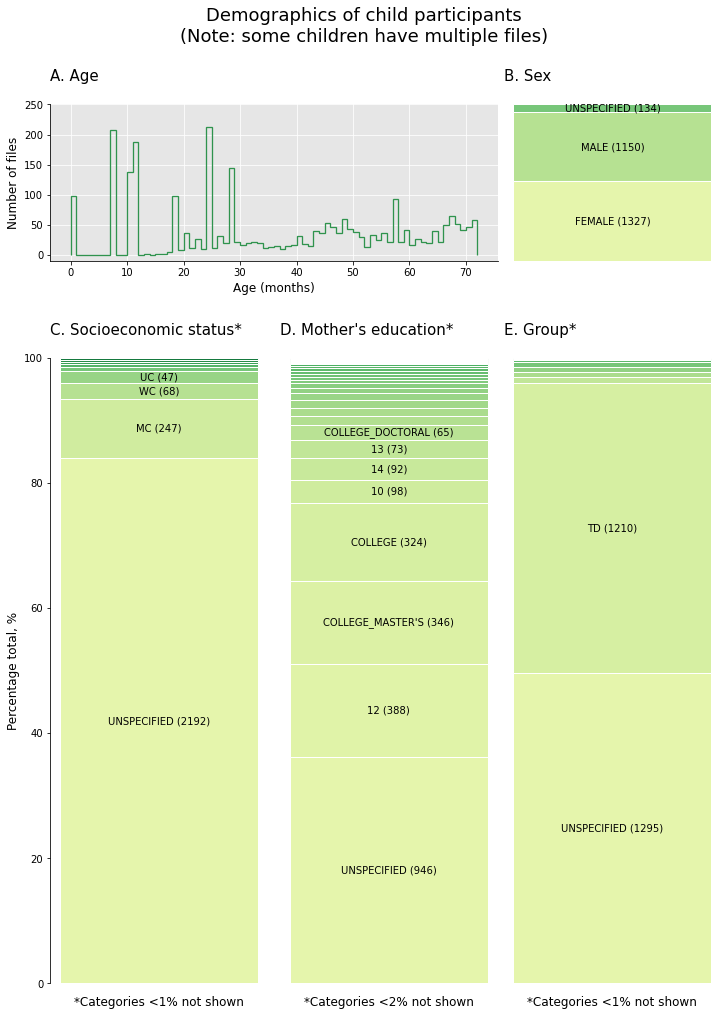

In [23]:
# Data for plotting
# Count files by 'sex', 'ses', 'mot_edu' or 'group'

sex_count = data_idx.groupby('sex').aggregate('count').file_path
ses_count = data_idx.groupby('ses').aggregate('count').file_path
mot_edu_count = data_idx.groupby('mot_edu').aggregate('count').file_path
group_count = data_idx.groupby('group').aggregate('count').file_path

# ==============================================================================
# Create a figure object

# Subplot dimension ratio
gs_kw = dict(width_ratios=[1,1,1], height_ratios=[1,4])

# Create a figure with 5 axes (i.e. 5 subplots), namely A, B, C, D, E
fig, ax = plt.subplot_mosaic([['A', 'A', 'B'],  # Subplot A spans across two grids
                              ['C', 'D', 'E']],
                              gridspec_kw=gs_kw, figsize=(10,14),
                              constrained_layout=True)
cmap = plt.cm.YlGn  # color map
accent_color = cmap(0.7)

# ==============================================================================
# Plotting

# ------------------------------------------------------------------------------
# Plot A
ax['A'].hist(data_idx.age_m, 72, histtype='step', color=accent_color, lw=1.3)

# ------------------------------------------------------------------------------
# Plot B to E

def plot_stack(ax_idx, data, colors, thres=0):
    data = data.sort_values(ascending=False)  # sort by count
    data_pc = data/sum(data)*100  # get percentage from count
    curr_sum = 0  # percentage sum (required for stacking bars)
    for i, pc in enumerate(data_pc):
        ax[ax_idx].bar('x', pc, label=data_pc.index[i], bottom=curr_sum,
                       color=colors[i], edgecolor='w', linewidth=1)
        curr_sum = curr_sum + pc  # for stacking bars  
        # make label
        if data.index[i] == '':
            label = "Unspecified ({})".format(data[i]).upper()
        elif pc >= thres:
            label = "{} ({})".format(data.index[i], data[i]).upper()
        else: label = ''
        label_ypos = curr_sum - (pc/2)
        ax[ax_idx].text(0, label_ypos, label, ha="center", va="center")

for k, v in {'B':sex_count, 'C':ses_count, 
             'D':mot_edu_count, 'E':group_count}.items():
    thres = 1
    colors = cmap(np.linspace(0.2, 0.8, len(v)))
    if k == 'B':
        thres = 0
        colors = cmap(np.linspace(0.2, 0.5, len(v)))
    elif k == 'D':
        thres = 2                    
    plot_stack(k, v, colors, thres)

# ==============================================================================
# Formatting

# ------------------------------------------------------------------------------
# Subplot A settings
ax['A'].set_xlabel('Age (months)', size=12)
ax['A'].set_ylabel('Number of files', size=12)
ax['A'].set_ylim([-10,250])
ax['A'].spines[['top', 'right']].set_visible(False)
ax['A'].grid(axis='both', color='w')
ax['A'].set_facecolor('0.9')

# ------------------------------------------------------------------------------
# Subplot B-E settings
for i in ['B','C','D','E']:
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel('Percentage total, %', size=12)
    ax[i].set_ylim([0,100])
    ax[i].spines[['top','bottom', 'right']].set_visible(False)
    if i in ['C','E']:
        ax[i].text(0,-2,'*Categories <1% not shown',ha="center", va="top", size=12)
    if i in ['B','D','E']:
        ax[i].get_yaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].spines['left'].set_visible(False)        
ax['D'].text(0,-2,'*Categories <2% not shown', ha="center", va="top", size=12)

# ------------------------------------------------------------------------------
# Set subplot titles
ax['A'].set_title('\nA. Age\n', loc = 'left', size=15)
ax['B'].set_title('\nB. Sex\n', loc = 'left', size=15)
ax['C'].set_title('\nC. Socioeconomic status*\n', loc = 'left', size=15)
ax['D'].set_title('\nD. Mother\'s education*\n', loc = 'left', size=15)
ax['E'].set_title('\nE. Group*\n', loc = 'left', size=15)

# Set figure title
fig.suptitle('Demographics of child participants\n(Note: some children have multiple files)', fontsize=18)

# Save figure
# plt.savefig('../reports/images/child_demgph_unprocessed.svg', bbox_inches='tight', dpi=150)
plt.show()

We are only interested in mother's CDS. Are there participants other than the child and their mother?

As shown above in the participant demographics, different corpora use different sets of labels and definitions for the same variable (e.g. mother's education). Besides, there are files that we don't need (e.g. children in groups other than typically development). Therefore, the dataset curated in this notebook needs to be cleaned a bit before further processing! 

---

# Pickling data

`data_idx` generated from this notebook will be pickled for further data processing and analysis later. The list of corpora identified in this notebook, `search_result`, will also be pickled for easier re-run of the notebook if needed. 

In [3]:
f1 = open('../data/childes/data_idx_unprocessed.pkl', 'wb')
pickle.dump(data_idx, f1, -1)
f1.close()

f2 = open('../data/childes/search_result.pkl', 'wb')
pickle.dump(search_result, f2, -1)
f2.close()